Imports

In [64]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder

[[1,2,3,4,5,6,7], [1,2,3,4,5,6,7]]

In [65]:
ds = pd.read_csv('falls_vs_normal.csv')
ds

,xAcc,yAcc,zAcc,xGyro,yGyro,zGyro,label
0,6.99,-0.57,-7.28,-2.75,-3.23,2.62,fall
1,6.51,-0.75,-6.93,-0.67,-6.35,4.64,fall
2,6.22,-0.63,-6.73,0.79,-5.49,3.85,fall
3,6.34,-0.62,-6.80,1.59,-2.26,0.67,fall
4,6.49,-0.39,-6.60,0.67,-0.24,-1.10,fall
...,...,...,...,...,...,...,...
96795,7.30,-1.16,-4.58,18.19,3.60,-35.77,light
96796,7.39,-0.37,-5.05,20.08,0.06,-34.55,light
96797,7.52,-1.46,-5.82,22.58,0.12,-28.02,light
96798,7.58,-2.14,-6.31,19.47,2.44,-22.52,light


In [66]:

def split_observations(ds, window_size):
  ds_arr = ds.to_numpy()
  observations = []
  y_values = []

  for i in range(0, len(ds_arr), window_size):
    observation = ds_arr[i:i + window_size, :-1]  # Slice a window, exclude last col
    observations.append(observation)

    # Append y value every window_size (i.e., every 400 values)
    if i % 400 == 0:  # Check for divisibility by 400, not remainder
      y_values.append(ds_arr[i, -1])  # Append only the last value of the window

  return np.array(observations), np.array(y_values)
        

In [67]:
WINDOW_SIZE = 400
x, y = split_observations(ds, WINDOW_SIZE)
x.shape, y.shape

((242, 400, 6), (242,))

In [68]:
X_train, y_train = x[:200], y[:200]
X_val, y_val = x[200:220], y[200:220]
X_test, y_test = x[220:], y[220:]
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape
X_train = X_train.astype('float32')
X_val = X_val.astype('float32')
X_test = X_test.astype('float32')

In [69]:
from sklearn.preprocessing import LabelEncoder

# Assuming y_train contains string labels
encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_val = encoder.transform(y_val)
y_test = encoder.transform(y_test)

# Reshape y_train (and similarly y_val, y_test) for multi-class classification
y_train = y_train.reshape(y_train.shape[0], 1)
y_val = y_val.reshape(y_val.shape[0], 1)
y_test = y_test.reshape(y_test.shape[0], 1)
y_train.shape, y_val.shape, y_test.shape

((200, 1), (20, 1), (22, 1))

In [70]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

In [71]:
model1 = Sequential()
model1.add(InputLayer((400,6)))
model1.add(LSTM(64))
model1.add(Dense(32, activation='relu'))
model1.add(Dense(7, activation='linear'))
model1.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_7 (LSTM)                   │ (None, 64)             │        18,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 7)              │           231 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,487 (80.03 KB)

 Trainable params: 20,487 (80.03 KB)

 Non-trainable params: 0 (0.00 B)

In [72]:
cp = ModelCheckpoint('model2/model.keras', save_best_only=True)
model1.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])

In [73]:
model1.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=5, callbacks=[cp])

Epoch 1/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 0.0902 - loss: 5.3461 - val_accuracy: 0.1000 - val_loss: 6.7930
Epoch 2/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.1717 - loss: 4.8460 - val_accuracy: 0.1000 - val_loss: 6.7557
Epoch 3/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.1884 - loss: 4.5316 - val_accuracy: 0.1000 - val_loss: 6.7285
Epoch 4/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.1974 - loss: 4.8173 - val_accuracy: 0.1000 - val_loss: 6.7024
Epoch 5/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.2103 - loss: 4.8052 - val_accuracy: 0.1000 - val_loss: 6.6833


In [74]:
from tensorflow.keras.models import load_model
model1 = load_model('model2/model.keras')

In [75]:
# Flatten the predictions array
train_predictions_flat = train_predictions.flatten()

# Ensure both arrays have the same length
min_length = min(len(train_predictions_flat), len(y_train_reshaped))
train_predictions_flat = train_predictions_flat[:min_length]
y_train_reshaped = y_train_reshaped[:min_length]

# Create DataFrame to compare predictions with actual labels
train_results = pd.DataFrame({'Train Predictions': train_predictions_flat, 'Actual': y_train_reshaped})

# Print the DataFrame
print(train_results)

     Train Predictions  Actual
0             0.982449       0
1             0.450557       0
2            -0.276248       0
3            -0.814473       0
4             0.722904       0
..                 ...     ...
195          -0.094360       6
196           0.892677       6
197           0.272693       6
198          -0.469950       6
199          -0.567231       6

[200 rows x 2 columns]


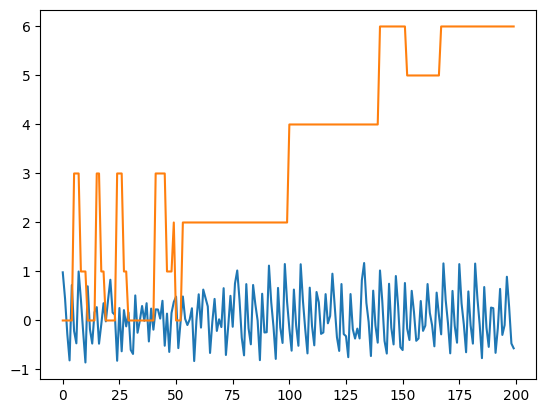

In [78]:
import matplotlib.pyplot as plt
plt.plot(train_results['Train Predictions'][:200])
plt.plot(train_results['Actual'][:200])